# requirements:
```
pandas
mecab-python3
scikit-learn
matplotlib
nlplt
```

In [1]:
import pandas as pd
import MeCab
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import rcParams
import nlplot

In [2]:
def mecab_sep(text,stopwords=['ため','とも']):
	m = MeCab.Tagger()
	node = m.parseToNode(text)
	words_list = []
	while node:
		if node.feature.split(",")[0] in ["名詞"] and node.surface not in stopwords:
			words_list.append(node.surface)
		node = node.next
	return words_list

### Bag-of-words / tf-idf
def calc_vecs(docs):
	vectorizer = TfidfVectorizer(analyzer=mecab_sep)
	vecs = vectorizer.fit_transform(docs)
	return vecs.toarray()

In [3]:
df = pd.read_csv("datasets/jk_rs_themes.csv",encoding='UTF-8')
tatget_labs = [
    '朝廣研','安部研','石田研','合志研','下川研',
    '成研','田中研','仲研','米元研','アプドゥハン研',
    '稲永研','于研','石田俊研','澤田研','安武研','前田研']

target_docs_df = df[df["研究室"].isin(tatget_labs )] 
target_docs_df.head()

年度 学科／研究科  研究室  学籍番号   賞  氏名   要旨                                    題目
3   H17  情報科学科   成研   NaN NaN NaN  NaN                 対面教育を支援するためのウェブ助言システム
6   H17  情報科学科   仲研   NaN NaN NaN  NaN                      生化学反応シミュレータの比較評価
7   H17  情報科学科  澤田研   NaN NaN NaN  NaN  FPGAを搭載したロボット教材のためのIPとしてKUE-CHIP2の検討
10  H17  情報科学科  稲永研   NaN NaN NaN  NaN              空港における目的地への交通手段検索システムの開発
11  H17  情報科学科  合志研   NaN NaN NaN  NaN              人の反応・判断能力測定用ドライビングシミュレータ

In [4]:
target_docs = target_docs_df["題目"].tolist()
all_docs_vecs = calc_vecs(target_docs_df["題目"])
n_clust = 10
# 参考：KMeans　k-means法によるクラスタリング
#  https://sabopy.com/py/scikit-learn-11/
vec = KMeans(n_clusters=n_clust, init="k-means++",n_init="auto")
vec.fit(all_docs_vecs)
m = len(vec.labels_)
vec.labels_[:10]

array([4, 8, 8, 4, 1, 8, 2, 8, 8, 6], dtype=int32)

In [5]:
# target_docs_df["クラス"] = vec.labels_
target_docs_df.loc[:,['クラスタ']] = vec.labels_
pd.crosstab(target_docs_df["研究室"],target_docs_df["クラスタ"])
cross_survive= pd.crosstab(target_docs_df['クラスタ'], target_docs_df['研究室'],normalize='index')
target_docs_df.head()

年度 学科／研究科  研究室  学籍番号   賞  氏名   要旨                                    題目  \
3   H17  情報科学科   成研   NaN NaN NaN  NaN                 対面教育を支援するためのウェブ助言システム   
6   H17  情報科学科   仲研   NaN NaN NaN  NaN                      生化学反応シミュレータの比較評価   
7   H17  情報科学科  澤田研   NaN NaN NaN  NaN  FPGAを搭載したロボット教材のためのIPとしてKUE-CHIP2の検討   
10  H17  情報科学科  稲永研   NaN NaN NaN  NaN              空港における目的地への交通手段検索システムの開発   
11  H17  情報科学科  合志研   NaN NaN NaN  NaN              人の反応・判断能力測定用ドライビングシミュレータ   

    クラスタ  
3      4  
6      8  
7      8  
10     4  
11     1

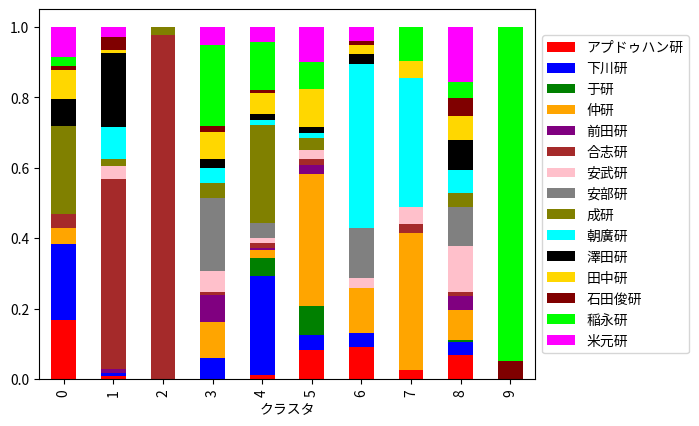

In [6]:
#文字化け
# plt.rcParams["font.family"] = "MS Gothic"
plt.rcParams["font.family"] = "Noto Sans CJK JP"
# plt.figure(figsize=[15,20])
#カラー
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", 
        ["red", "blue", "green","orange", "purple", "brown", "pink", "gray", "olive", "cyan", 
         "black", "gold", "maroon", "lime", "fuchsia", "tan"])

cross_survive.plot.bar(stacked=True)
plt.legend( loc='center left', bbox_to_anchor=(1., .5))
# 注意：クラスタリング結果は初期値によって変わる

In [7]:
k=5
df1 = target_docs_df[target_docs_df['クラスタ']==k]
df1.head()

年度 学科／研究科      研究室  学籍番号   賞  氏名   要旨                                題目  \
36   H17  情報科学科       成研   NaN NaN NaN  NaN                   RFID無人レジシステムの試作   
70   H17  情報科学科       仲研   NaN NaN NaN  NaN  ウェブマセマティカによる生化学シミュレーションウェブサイトの試作   
122  H17  情報科学科       仲研   NaN NaN NaN  NaN          Excelを利用した生化学反応シミュレータの試作   
174  H18  情報科学科  アプドゥハン研   NaN NaN NaN  NaN            車椅子使用者向け地図情報ナビゲーションの試作   
200  H18  情報科学科  アプドゥハン研   NaN NaN NaN  NaN      セマンティックグリッド・フレームワークプロトタイプの試作   

     クラスタ  
36      5  
70      5  
122     5  
174     5  
200     5

In [8]:
# 研究室リスト（件数の多い順）
vc = df1['研究室'].value_counts()
n = sum(vc.values)
print(n)
title=",".join([f"{k}({c})" for k,c in vc.items() if c>0.05*n])
print(title)

120
仲研(45),田中研(13),米元研(12),アプドゥハン研(10),于研(10),稲永研(9)


In [9]:
texts =[]
for text in df1['題目'].values:
    texts += [" ".join(mecab_sep(text))]
texts[:5]

['RFID 無人 レジ システム 試作',
 'ウェブマセマティカ 化学 シミュレーション ウェブサイト 試作',
 'Excel 利用 化学 反応 シミュレータ 試作',
 '車 椅子 使用 地図 情報 ナビゲーション 試作',
 'セマンティック グリッド フレームワーク プロトタイプ 試作']

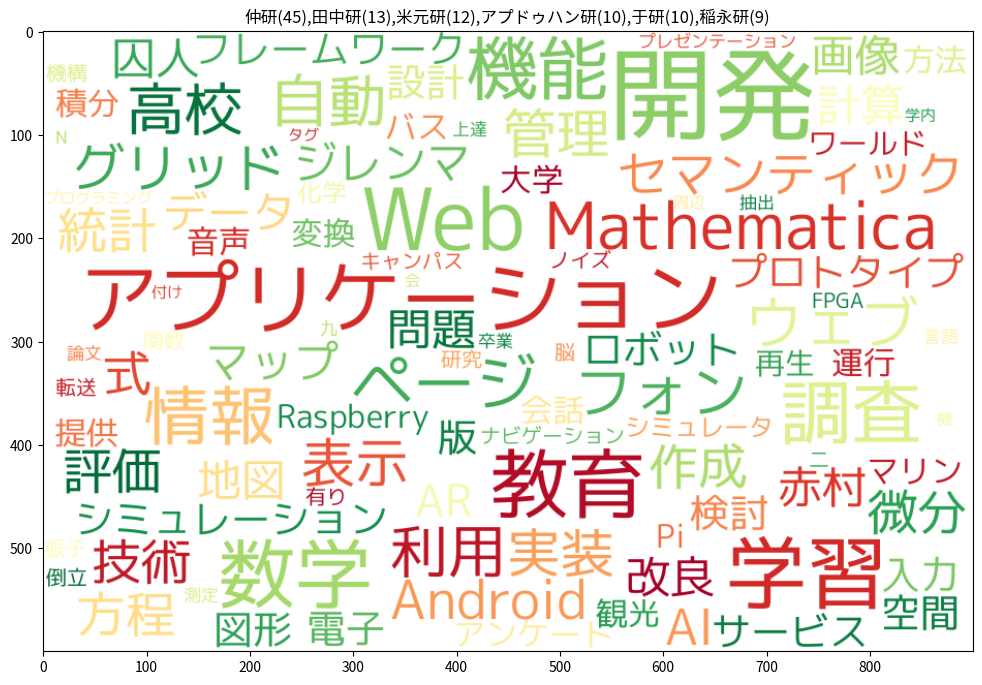

In [10]:
df2 = pd.DataFrame({'text': texts})
npt = nlplot.NLPlot(df2, target_col='text')
# Stopword calculations can be performed.
stopwords = npt.get_stopword(top_n=4, min_freq=0)

fig = plt.figure(figsize=(12, 20))
fig.tight_layout()
fig_wc = npt.wordcloud(
    width = 900,
    height = 600,
    max_words = 100,
    max_font_size = 100,
    colormap = 'RdYlGn', # 'tab20_r',
    stopwords =stopwords,
    mask_file = None,
    save=False
)

# plt.axis('off') 
plt.title(title)
plt.imshow(fig_wc, interpolation="bilinear")      
plt.show()

Cluster No.0: 成研(27),下川研(23),アプドゥハン研(18),米元研(9),田中研(9),澤田研(8)


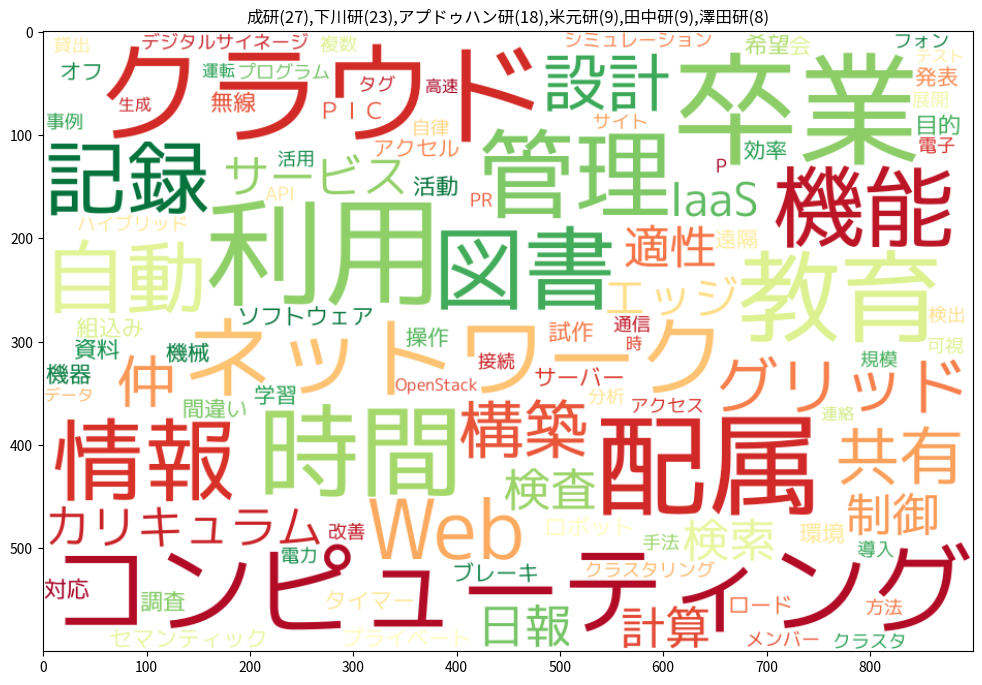

Cluster No.1: 合志研(59),澤田研(23),朝廣研(10)


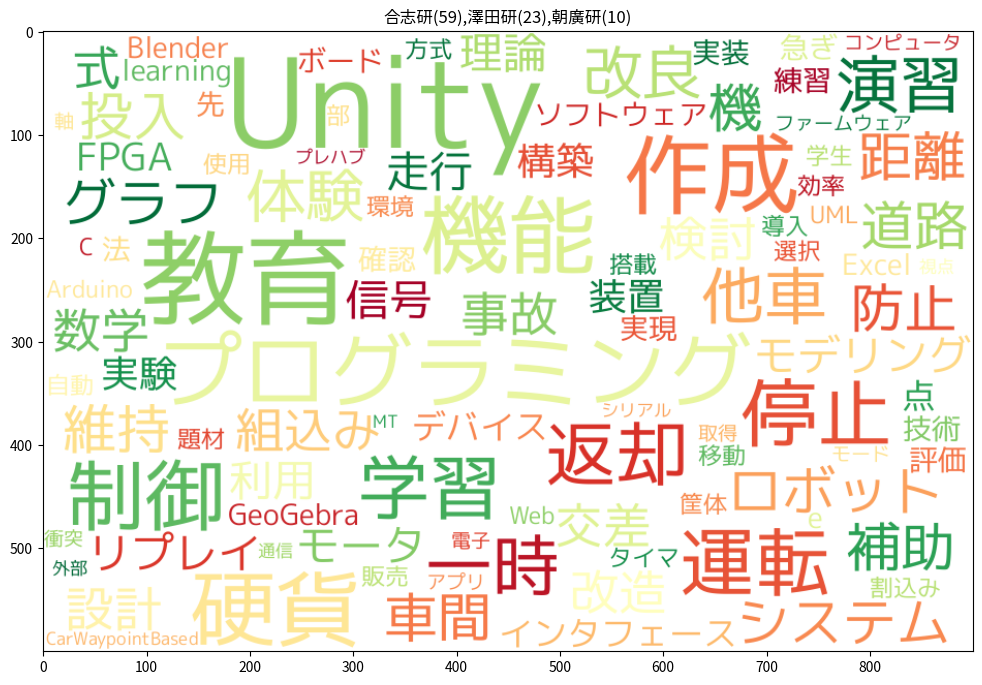

Cluster No.2: 合志研(43)


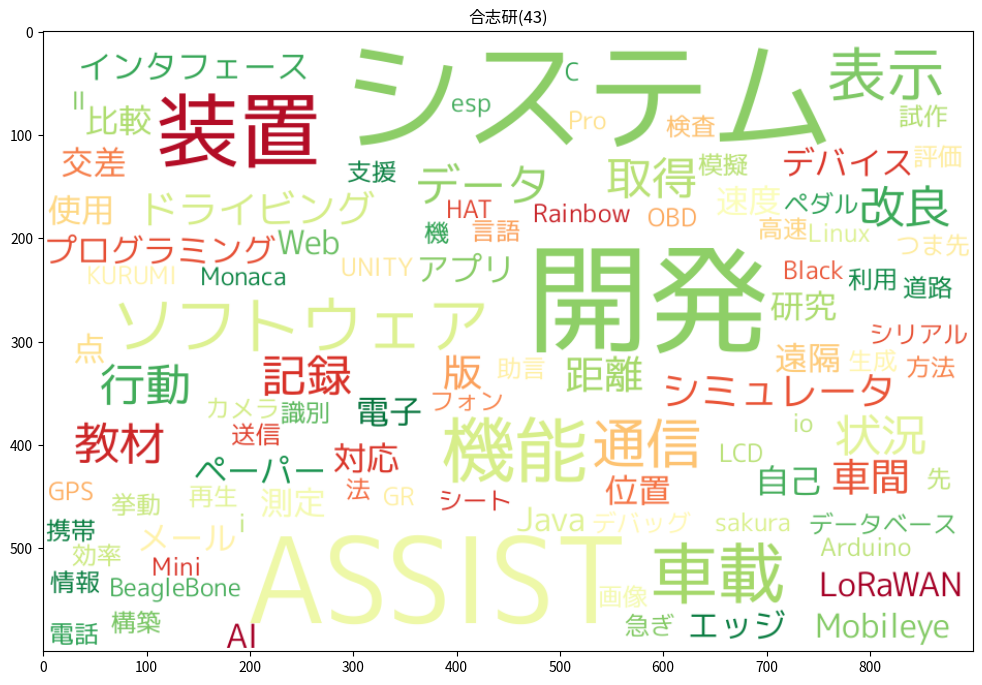

Cluster No.3: 稲永研(27),安部研(24),仲研(12),田中研(9),前田研(9),下川研(7),安武研(7),米元研(6)


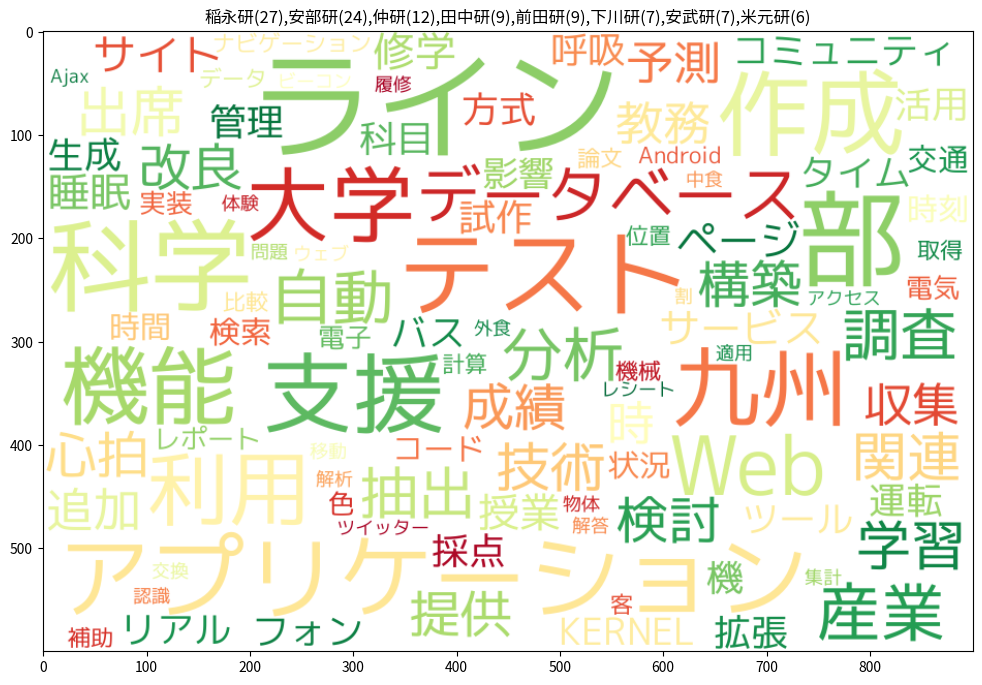

Cluster No.4: 下川研(80),成研(79),稲永研(39),田中研(17)


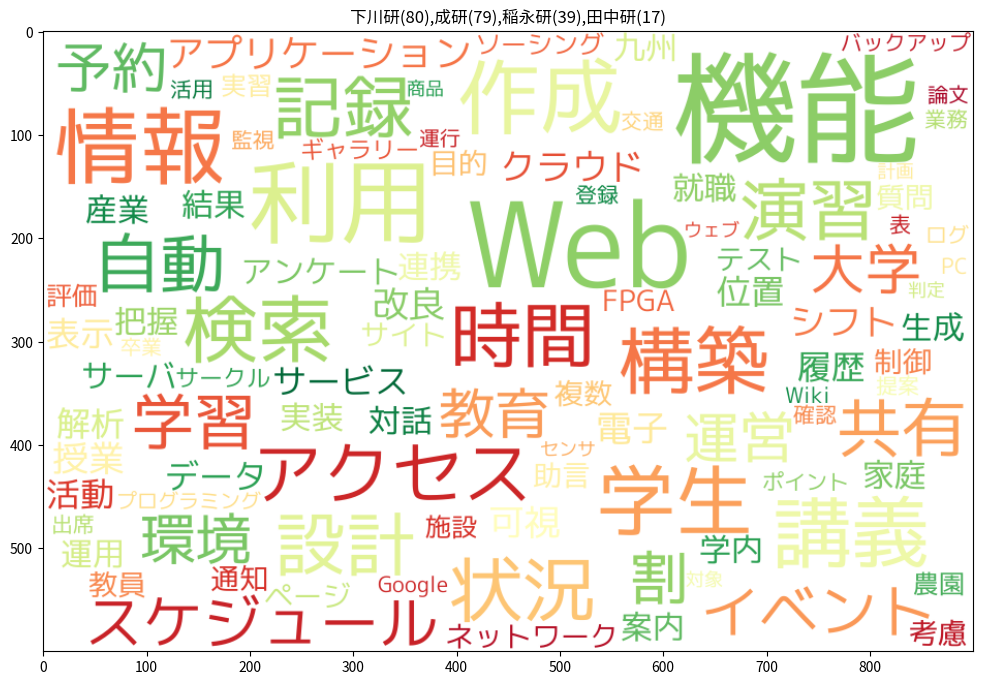

Cluster No.5: 仲研(45),田中研(13),米元研(12),アプドゥハン研(10),于研(10),稲永研(9)


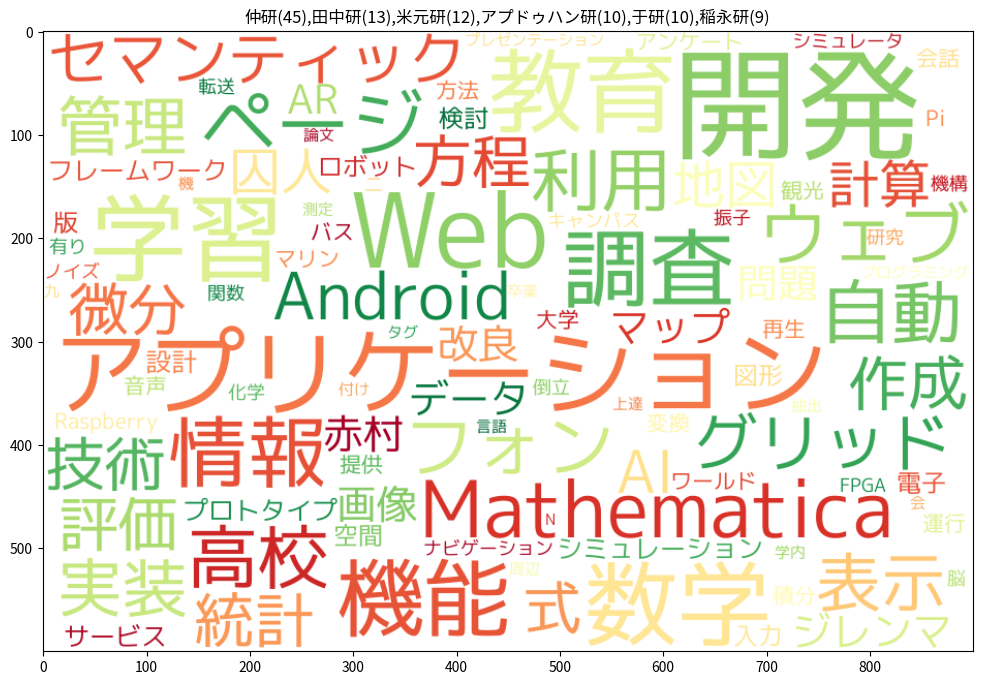

Cluster No.6: 朝廣研(36),安部研(11),仲研(10),アプドゥハン研(7)


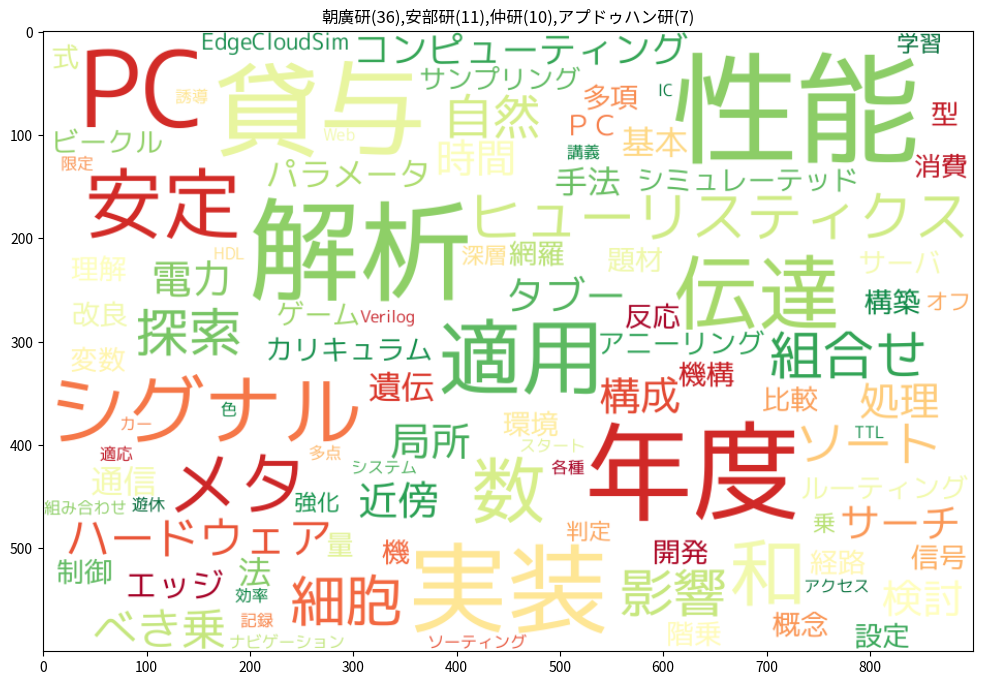

Cluster No.7: 仲研(16),朝廣研(15),稲永研(4)


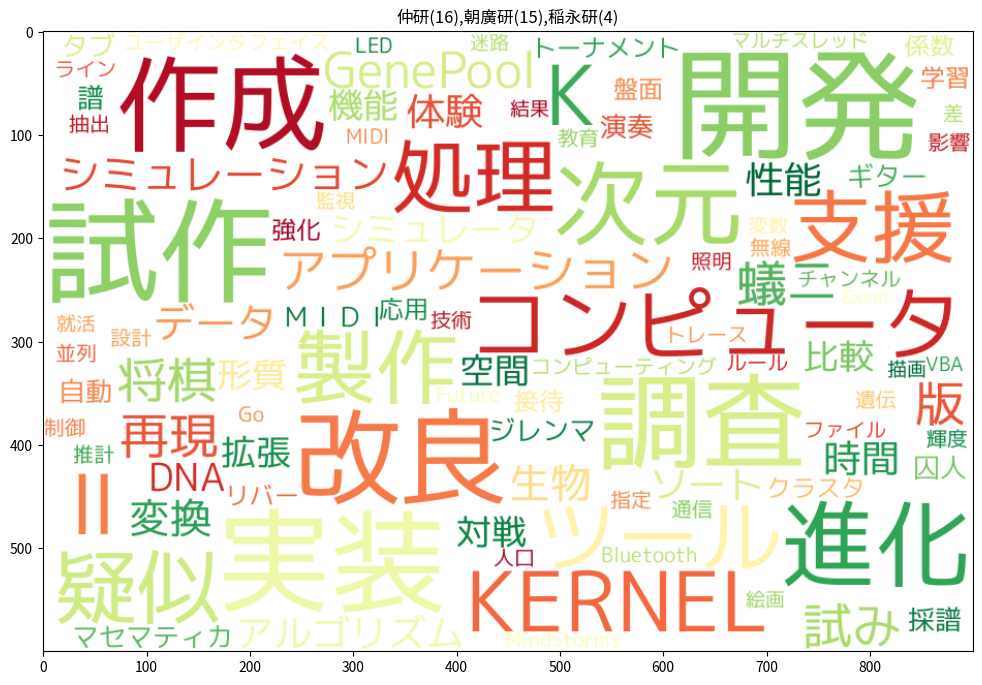

Cluster No.8: 米元研(98),安武研(81),安部研(68),澤田研(53),仲研(52),アプドゥハン研(43),田中研(42),朝廣研(41)


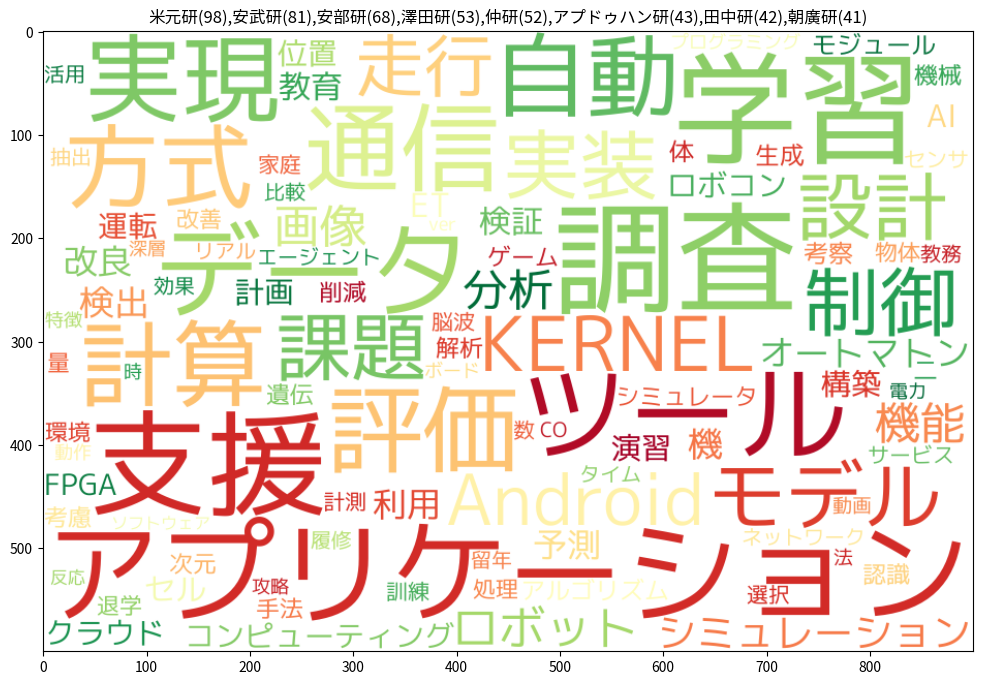

Cluster No.9: 稲永研(38)


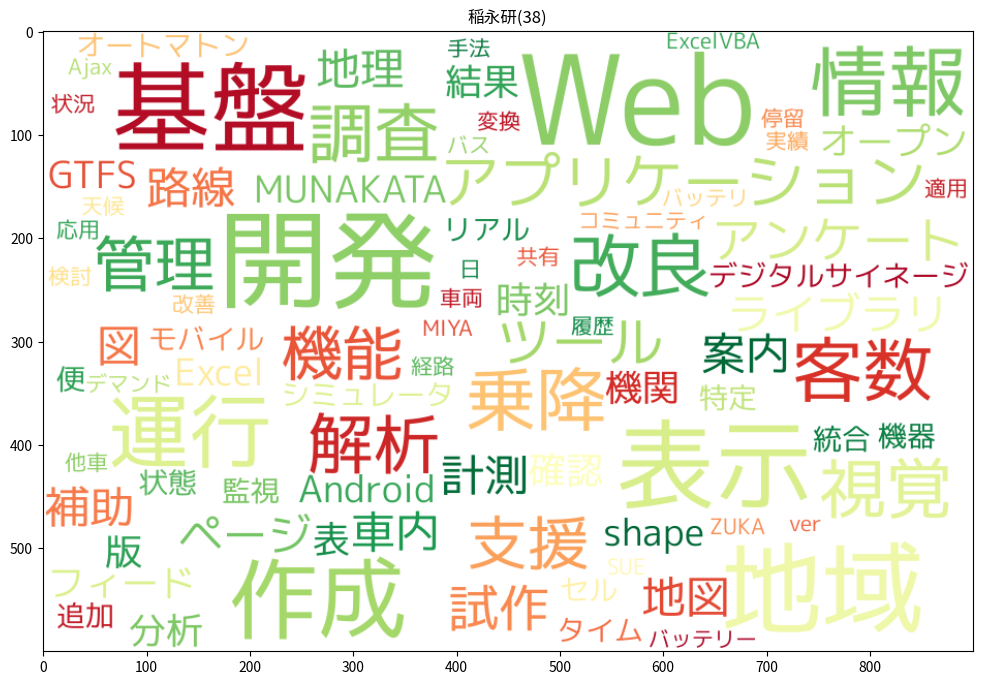

In [11]:
for k in range(n_clust):
    df1 = target_docs_df[target_docs_df['クラスタ']==k]
    vc = df1['研究室'].value_counts()
    n = sum(vc.values)
    title=",".join([f"{k}({c})" for k,c in vc.items() if c>0.05*n])
    print(f"Cluster No.{k}: {title}")
    
    texts =[]
    for text in df1['題目'].values:
        texts += [" ".join(mecab_sep(text))]
    df2 = pd.DataFrame({'text': texts})
    
    npt = nlplot.NLPlot(df2, target_col='text')
    # Stopword calculations can be performed.
    stopwords = npt.get_stopword(top_n=4, min_freq=0)
    
    fig = plt.figure(figsize=(12, 20))
    fig.tight_layout()
    fig_wc = npt.wordcloud(
        width = 900,
        height = 600,
        max_words = 100,
        max_font_size = 120,
        colormap = 'RdYlGn', # 'tab20_r',
        stopwords =stopwords,
        mask_file = None,
        save=False
    )
    
    # plt.axis('off') 
    plt.title(title)
    plt.imshow(fig_wc, interpolation="bilinear")      
    plt.show()